In [14]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

## 0. 初期設定

In [15]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [16]:
import os
import torch
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer, 
    MeshRendererWithFragments,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [39]:
#!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

from pytorch3d.renderer.mesh.clip import (
    clip_faces,
    ClipFrustum,
    convert_clipped_rasterization_to_original_faces,
)

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# 1. Pytorch3Dでメッシュの読み込み

In [45]:
# パス設定
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# objファイルをロード
mesh = load_objs_as_meshes([obj_filename], device=device)

# 大きさの正規化（計算速度を早くするため）
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)))

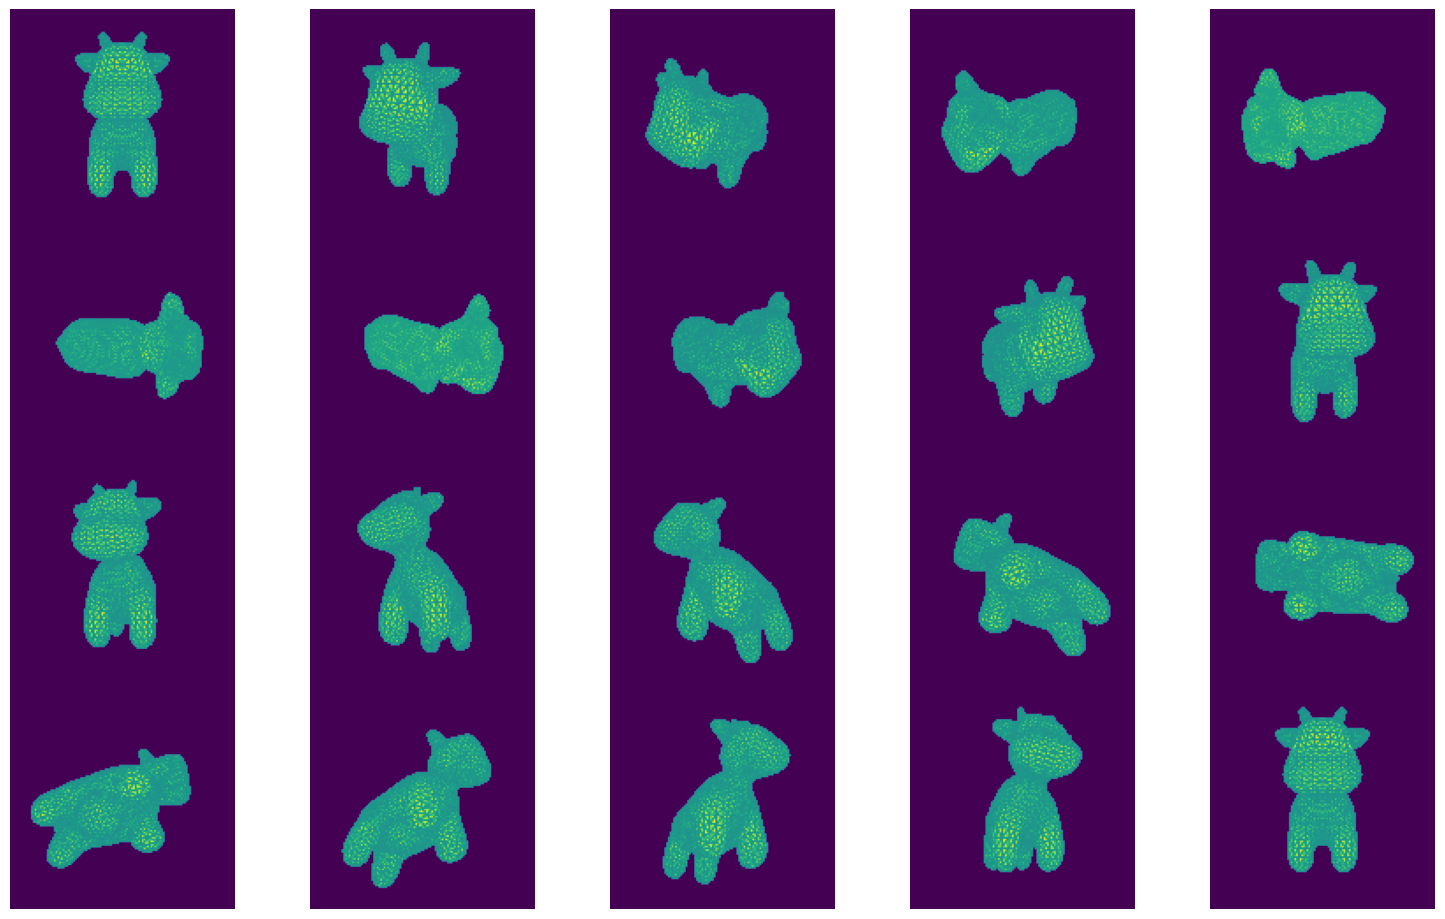

In [61]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 20

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 

raster_settings = RasterizationSettings(
    image_size=128, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights
    )
)

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(num_views)

# Render the cow mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

# RGB images
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

In [65]:
#レンダリング設定
sigma = 5.1e-7
image_size=128
faces_per_pixel=30

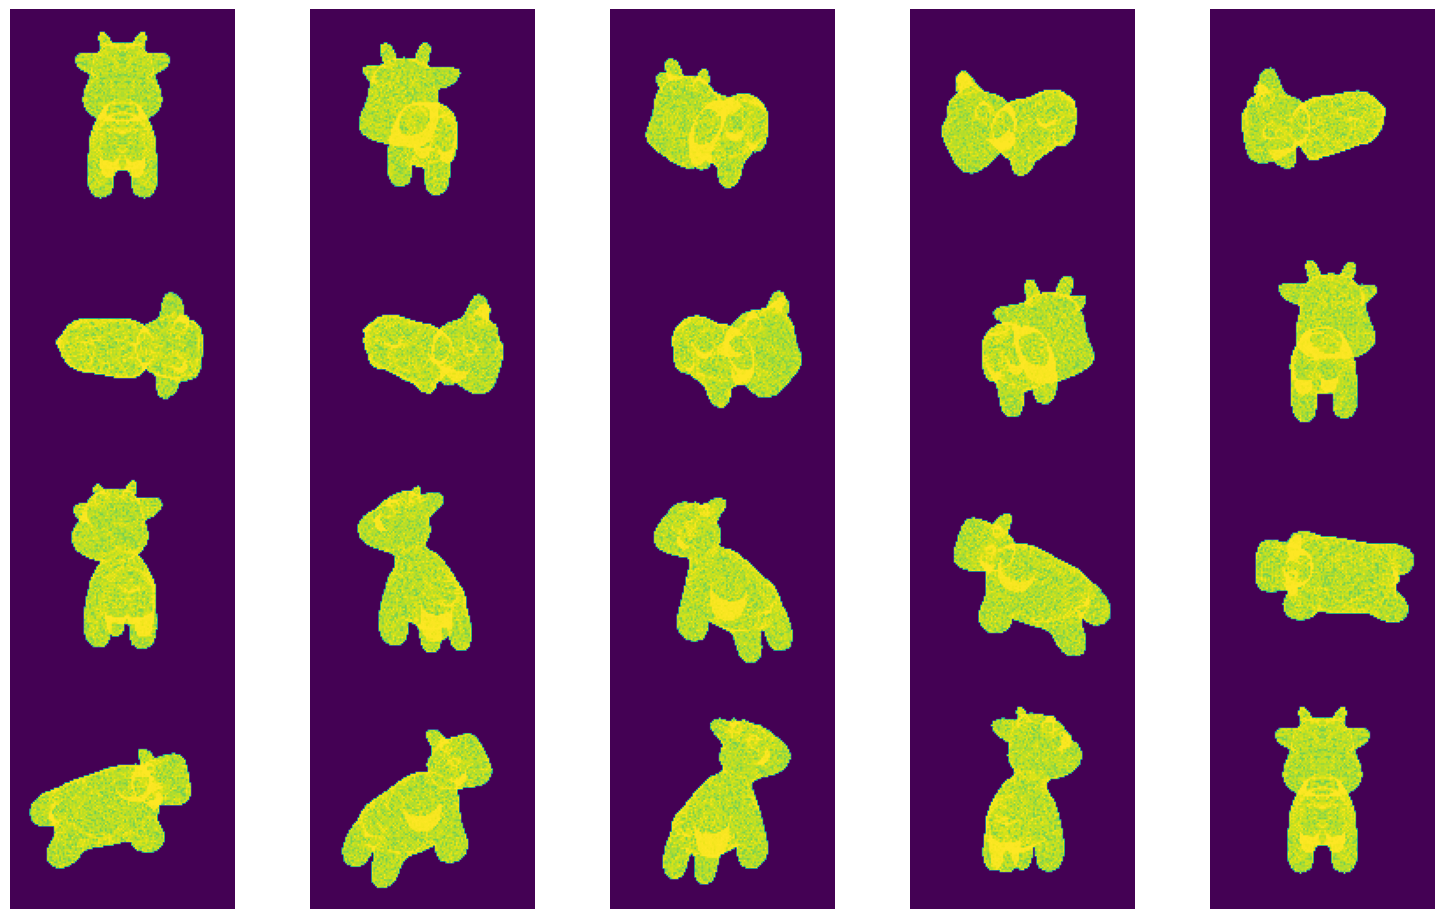

In [66]:
# Rasterization settings for silhouette rendering  
raster_settings_silhouette = RasterizationSettings(
    image_size=image_size, 
    blur_radius=np.log(1. / sigma - 1.)*sigma, 
    faces_per_pixel=faces_per_pixel, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

In [67]:
renderer_frag = MeshRendererWithFragments(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

silhouette_images , fragments = renderer_frag(meshes, cameras=cameras, lights=lights)
fragments.dists[0][64][64]

tensor([-3.5724e-06,  3.5724e-06, -7.0618e-06,  7.0618e-06, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00],
       device='cuda:0')

In [69]:
d = (1 + torch.exp( (-fragments.dists[0][64][64])  / sigma)) ** -1
d2 = torch.sigmoid(fragments.dists[0][64][64]  / sigma)

print(d)
print(d2)

tensor([9.0674e-04, 9.9909e-01, 9.6927e-07, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       device='cuda:0')
tensor([9.0674e-04, 9.9909e-01, 9.6927e-07, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       device='cuda:0')


In [71]:
mask = fragments.pix_to_face[0][64][64] >= 0

print(fragments.pix_to_face[0][64][64])

prob_map = torch.sigmoid(-fragments.dists[0][64][64] / sigma) * mask

print(prob_map)

tensor([2319, 2318, 2838, 2839,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
          -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
          -1,   -1,   -1,   -1,   -1,   -1], device='cuda:0')
tensor([9.9909e-01, 9.0674e-04, 1.0000e+00, 9.6927e-07, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       device='cuda:0')


## 3. Mesh prediction via silhouette rendering
In the previous section, we created a dataset of images of multiple viewpoints of a cow.  In this section, we predict a mesh by observing those target images without any knowledge of the ground truth cow mesh.  We assume we know the position of the cameras and lighting.

We first define some helper functions to visualize the results of our mesh prediction:

In [73]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette, 
                         target_image=target_rgb[1], title='', 
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

Starting from a sphere mesh, we will learn offsets of each vertex such that the predicted mesh silhouette is more similar to the target silhouette image at each optimization step.  We begin by loading our initial sphere mesh:

In [74]:
# We initialize the source shape to be a sphere of radius 1.  
src_mesh = ico_sphere(4, device)

We create a new differentiable renderer for rendering the silhouette of our predicted mesh:

In [75]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = sigma
raster_settings_soft = RasterizationSettings(
    image_size=image_size, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=faces_per_pixel, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

In [76]:
#open3dTEST
import copy
import open3d as o3d

# Loading mesh data
print("Loading mesh data")
Mesh = o3d.io.read_triangle_mesh("data/cow_mesh/cow.obj")

# Confirmation
print(Mesh)
print('Vertices:')
print(np.asarray(Mesh.vertices))
print('Triangles:')
print(np.asarray(Mesh.triangles))

# Calculation of normal vector   
Mesh.compute_vertex_normals()
print(np.asarray(Mesh.triangle_normals))

Loading mesh data
TriangleMesh with 3225 points and 5856 triangles.
Vertices:
[[ 0.31728801 -0.397295    0.36444801]
 [ 0.31312099 -0.40468001  0.424303  ]
 [ 0.28963801 -0.411984    0.36304399]
 ...
 [-0.0407812  -0.0765567   1.00299001]
 [ 0.         -0.0952192   1.02642   ]
 [-0.0264068  -0.0851806   1.03685999]]
Triangles:
[[   0    1    2]
 [   3    2    1]
 [   4    5    6]
 ...
 [2777 3221 2776]
 [2773 2776 3224]
 [2769 3224 2776]]
[[ 0.47080251 -0.87898713 -0.0756744 ]
 [ 0.45360709 -0.88860867 -0.06793553]
 [ 0.66639611 -0.74349975 -0.05589594]
 ...
 [-0.142016    0.07586253  0.98695305]
 [-0.44241811 -0.42041917  0.79215777]
 [-0.43089018 -0.43938066  0.78821208]]


In [38]:
renderer_frag = MeshRendererWithFragments(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

silhouette_images , fragments = renderer_frag(meshes, cameras=cameras, lights=lights)
#fragments.dists[0][64][64]

In [83]:
#指定したmeshを削除する
copy_mesh = copy.deepcopy(Mesh)
print(copy_mesh)

o3d.io.write_triangle_mesh("output/output_test.obj",copy_mesh)

arr = fragments.pix_to_face[0][64][64].cpu().numpy().copy()
print(arr)

copy_mesh.triangles = o3d.utility.Vector3iVector(np.delete(np.asarray(copy_mesh.triangles), arr, 0))
copy_mesh.triangle_normals = o3d.utility.Vector3dVector(np.delete(np.asarray(copy_mesh.triangle_normals), arr, 0))

print(copy_mesh)
o3d.visualization.draw_geometries([copy_mesh])
o3d.io.write_triangle_mesh("output/output_test.obj",copy_mesh)

TriangleMesh with 3225 points and 5856 triangles.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write PNG failed: image has no data.
[Open3D WARNING] Write OBJ successful, but failed to write texture file.
[2319 2318 2838 2839   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1   -1]
TriangleMesh with 3225 points and 5851 triangles.
[Open3D WARNING] Write OBJ can not include triangle normals.


True

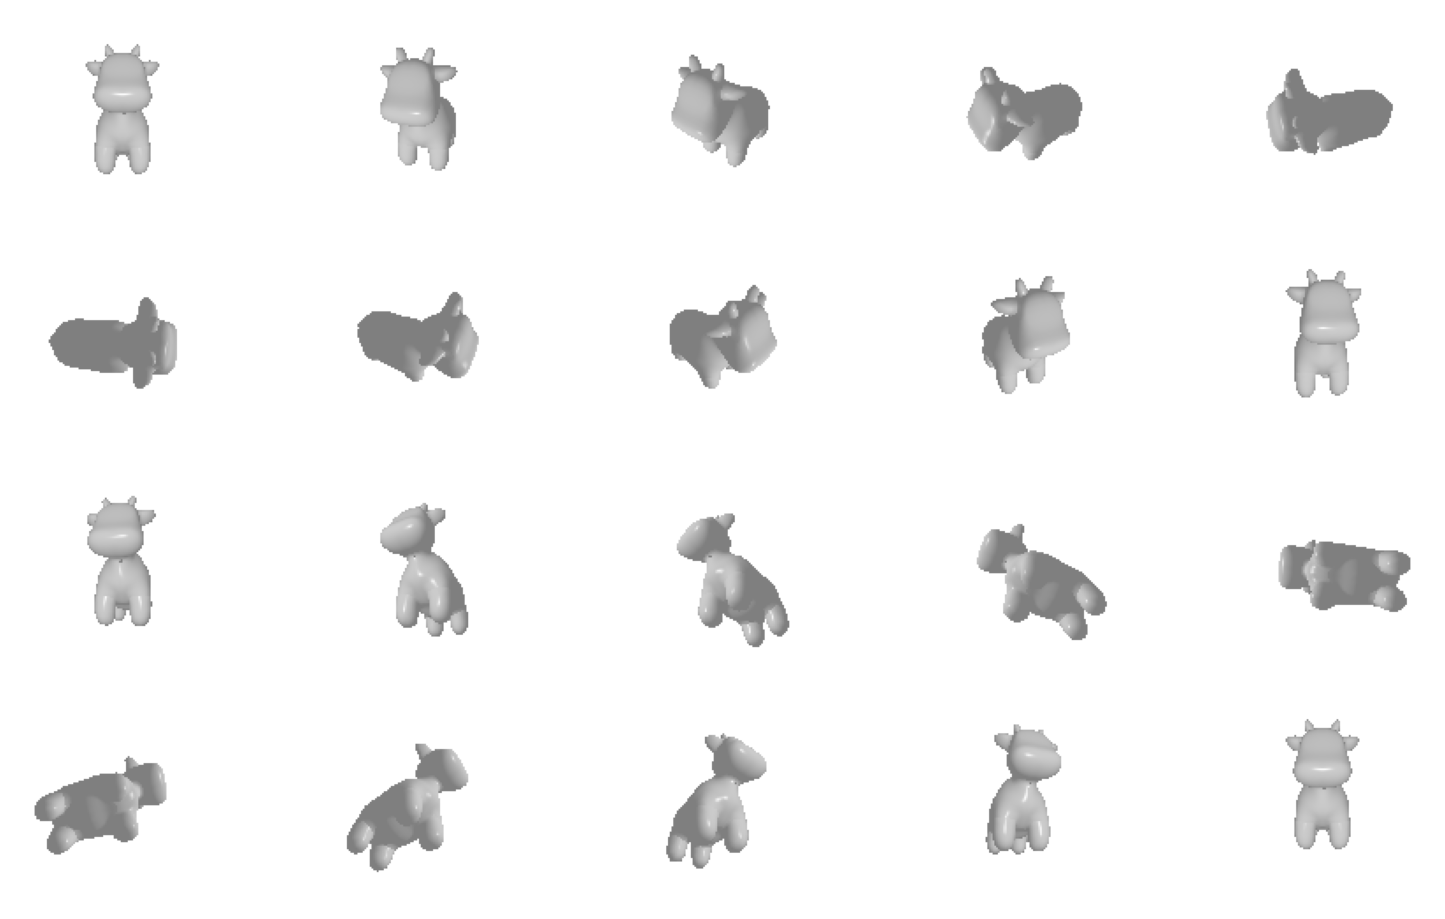

In [82]:
from pytorch3d.io import load_obj, save_obj
# We read the target 3D model using load_obj
verts, faces, aux = load_obj("./output/output_test.obj")

sigma = 5.1e-7
raster_settings_soft = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=30, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]


# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# We construct a Meshes structure for the target mesh
mesh = Meshes(verts=[verts], faces=[faces_idx], textures = textures)

meshes = mesh.extend(num_views)

# Render the cow mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

# RGB images
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
plt.show()